# Setup

In [1]:
!pip install tweepy

# basic tweepy setup
import tweepy
consumer_key="BQn1nUJgENsX6dZEpGTwV3v8V"
consumer_key_secret="RYjJTGnm0r6Jrypl3SwaGuQIJMhyk6zboq4vxDAWChJU9p4L87"
access_token="1226465414819065856-k4LQY3zCPXd8iFZrK0QgfdOVtF6U6S"
access_token_secret="fxPd0TIlu3g6iM3JGDHgKIFpjNiuUnoSOyaELjtQUk928"

auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth) 

In [2]:
!pip install pymongo

# basic setup of database connection and parameters for future interaction with twitter API
from tweepy.streaming import StreamListener
import pymongo
from pymongo import MongoClient
import pprint
language="en"
keywords = ['super tuesday', 'bernie', 'warren', 'trump', 'biden', 'buttigieg', 'bloomberg', 'klobuchar', 'sanders', 'democratic', 'primary']
client = MongoClient()
db = client.twitter_data
print(db)
tweets = db.tweets

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'twitter_data')


In [316]:
#listener class for the stream api
import json
class MongoListener(StreamListener):
    def __init__(self):
        self.duplicates = 0
    def on_data(self, data):
        data_json = json.loads(data)
        if "id" in data_json.keys():
            data_json["_id"] = data_json.pop("id")
            try:
                tweets.insert_one(data_json)
            except pymongo.errors.DuplicateKeyError:
                self.duplicates+=1
        return True

    def on_error(self, status):
        print(status)

# Data retrieval

In [3]:
# Using the stream api to retreive live stream data filtering for the keywords and language
# Interrupt the cell when you retrieve satisfactory amount of data
def filter_stream(keywords, language):
    mongo_listener = MongoListener()
    stream = tweepy.Stream(auth = api.auth, listener=mongo_listener, tweet_mode="extended")
    stream.filter(track=keywords, languages=[language])


In [4]:
#Using REST api to retreive search results for selected keywords and language
def search_keywords(keywords):
    """Performs an API search request for 100 tweets of each keyword given and adds them to the mongo-db"""
    duplicates = 0
    for keyword in keywords:
        print('Searching for keyword {}'.format(keyword))
        search_results = api.search(q=keyword, count=100, lang=language, tweet_mode="extended")
        for result in search_results:
            json_result = result._json
            json_result["_id"] = json_result.pop("id")
            try:
                tweets.insert_one(json_result)
            except pymongo.errors.DuplicateKeyError:
                duplicates+=1
                continue
    print("Number of duplicates: {}".format(duplicates))
    
def search_users(users):
    """Performs an API timeline request for the most recent 20 tweets of each user given and adds them to the mongo-db"""
    duplicates = 0
    for user in users:
        print("Fetching user {}".format(user))
        search_results = api.user_timeline(screen_name=user, count=20, tweet_mode="extended")
        for result in search_results:
            json_result = result._json
            json_result["_id"] = json_result.pop("id")
            try:
                tweets.insert_one(json_result)
            except pymongo.errors.DuplicateKeyError:
                duplicates+=1
                continue
    print("Number of duplicates in total: {}".format(duplicates))

# Data analysis

### K-means clustering

In [2]:
#Tokenizer and normalizer using spacy
!pip install spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['ner'])

# nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

def spacy_tokenize(string):
    tokens = []
    doc = nlp(string)
    for token in doc:
        tokens.append(token)
    return tokens

def normalize(tokens):
    normalized_tokens = []
    for token in tokens:
        normalized = token.text.lower().strip()
        if ((token.is_alpha or token.is_digit)):
            normalized_tokens.append(normalized)
    return normalized_tokens

def tokenize_normalize(string):
    return normalize(spacy_tokenize(string))

In [97]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import itertools
import json

def fetch_tweets(retweets=False, sample=False):
    """Fetches all tweets, assumes you have a local mongo client running and have a database called twitter_data_full with tweets collection"""
    if not sample:
        client = MongoClient()
        db = client.twitter_data_full
        print("Connected to: ", db, '\n')
        tweets = db.tweets
    tweets_tmp = []
    if retweets:
        query= {}
    else:
        query = {"retweeted_status":None}
    if sample:
        with open("sample.json") as infile:
            data = json.load(infile)
            for tweet in data["tweets"]:
                if tweet.get("retweeted_status", False):
                    tweets_tmp.append([tweet["_id"], tweet.get("retweeted_status").get("extended_tweet", tweet).get("full_text", tweet.get("text")), tweet["entities"], tweet.get("in_reply_to_screen_name", None), tweet["user"], tweet.get("user_mentions", None), tweet.get("retweeted_status")])
                else:
                    tweets_tmp.append([tweet["_id"], tweet.get("extended_tweet", tweet).get("full_text", tweet.get("text")), tweet["entities"], tweet.get("in_reply_to_screen_name", None), tweet["user"], tweet.get("user_mentions", None), None])
    else:
        for tweet in tweets.find(query):
            if tweet.get("retweeted_status", False):
                tweets_tmp.append([tweet["_id"], tweet.get("retweeted_status").get("extended_tweet", tweet).get("full_text", tweet.get("text")), tweet["entities"], tweet.get("in_reply_to_screen_name", None), tweet["user"], tweet.get("user_mentions", None), tweet.get("retweeted_status")])
            else:
                tweets_tmp.append([tweet["_id"], tweet.get("extended_tweet", tweet).get("full_text", tweet.get("text")), tweet["entities"], tweet.get("in_reply_to_screen_name", None), tweet["user"], tweet.get("user_mentions", None), None])
    tweet_frame = pd.DataFrame(tweets_tmp, columns = ["id", "text", "entities", "in_reply_to_screen_name", "user", "user_mentions", "retweet_status"])
    if retweets:
        print("Retrieved {} tweets including retweets.".format(tweet_frame.shape[0]))
    else:
        print("Retrieved {} tweets without retweets.".format(tweet_frame.shape[0]))
    return tweet_frame
tweet_frame = fetch_tweets(sample=True)
print(tweet_frame.head())


Retrieved 100 tweets without retweets.
                    id                                               text  \
0  1234886450803593216  FFA Students at Coldwater High School in Ohio ...   
1  1234886450811895814  Hey whatever happened to that next caravan of ...   
2  1234886450849755136  So @realDonaldTrump wants to make mental fitne...   
3  1234886450836996097  According to Bloomberg’s Jonathan Bernstein, “...   
4  1234886450853896192  I am begging Warren twitter to stop this shit....   

                                            entities in_reply_to_screen_name  \
0  {'hashtags': [], 'urls': [], 'user_mentions': ...                    None   
1  {'hashtags': [], 'urls': [], 'user_mentions': ...                    None   
2  {'hashtags': [], 'urls': [], 'user_mentions': ...                    None   
3  {'hashtags': [], 'urls': [{'url': 'https://t.c...         Dragonfly_Drama   
4  {'hashtags': [], 'urls': [], 'user_mentions': ...                    None   

                 

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# setup for clustering, keys allow me to retrieve the tweets back after clustering
num_clusters = 2500
tweet_vals = tweet_frame["text"].tolist()
tweet_keys = tweet_frame["id"].tolist()

# create a vectorized representation of the tweets text field
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, tokenizer=tokenize_normalize, ngram_range=(1,2), max_features=50000)
tfidf_vectorizer.fit(tweet_vals)
tfidf_document_term_matrix = tfidf_vectorizer.transform(tweet_vals)
vectorizer = tfidf_vectorizer

In [6]:
# run minibatch kmeans on the document term matrix
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=3, verbose=10, batch_size = 3000, init_size=10000).fit(tfidf_document_term_matrix)

Init 1/3 with method: k-means++
Inertia for init 1/3: 8964.982752
Init 2/3 with method: k-means++
Inertia for init 2/3: 8919.449942
Init 3/3 with method: k-means++
Inertia for init 3/3: 8965.183289
Minibatch iteration 1/1900: mean batch inertia: 0.900508, ewa inertia: 0.900508 
Minibatch iteration 2/1900: mean batch inertia: 0.903201, ewa inertia: 0.900795 
Minibatch iteration 3/1900: mean batch inertia: 0.911115, ewa inertia: 0.901897 
Minibatch iteration 4/1900: mean batch inertia: 0.902930, ewa inertia: 0.902007 
Minibatch iteration 5/1900: mean batch inertia: 0.902050, ewa inertia: 0.902012 
Minibatch iteration 6/1900: mean batch inertia: 0.901512, ewa inertia: 0.901959 
Minibatch iteration 7/1900: mean batch inertia: 0.899222, ewa inertia: 0.901666 
Minibatch iteration 8/1900: mean batch inertia: 0.902157, ewa inertia: 0.901719 
Minibatch iteration 9/1900: mean batch inertia: 0.898573, ewa inertia: 0.901383 
[MiniBatchKMeans] Reassigning 1500 cluster centers.
Minibatch iteration 1

Minibatch iteration 90/1900: mean batch inertia: 0.868961, ewa inertia: 0.870924 
Minibatch iteration 91/1900: mean batch inertia: 0.876502, ewa inertia: 0.871520 
[MiniBatchKMeans] Reassigning 1500 cluster centers.
Minibatch iteration 92/1900: mean batch inertia: 0.868356, ewa inertia: 0.871182 
Minibatch iteration 93/1900: mean batch inertia: 0.867552, ewa inertia: 0.870795 
Minibatch iteration 94/1900: mean batch inertia: 0.872068, ewa inertia: 0.870930 
Minibatch iteration 95/1900: mean batch inertia: 0.878125, ewa inertia: 0.871699 
[MiniBatchKMeans] Reassigning 1500 cluster centers.
Minibatch iteration 96/1900: mean batch inertia: 0.879950, ewa inertia: 0.872580 
Minibatch iteration 97/1900: mean batch inertia: 0.869090, ewa inertia: 0.872207 
Minibatch iteration 98/1900: mean batch inertia: 0.870883, ewa inertia: 0.872066 
Minibatch iteration 99/1900: mean batch inertia: 0.872887, ewa inertia: 0.872153 
[MiniBatchKMeans] Reassigning 1500 cluster centers.
Minibatch iteration 100/

In [92]:
import collections
import numpy as np
# Group the posts by their cluster labels.
clustering = collections.defaultdict(list)
for idx, label in enumerate(kmeans.labels_):
    clustering[label].append(idx)
    
query_keywords = set()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
# print clusters and their defining words
for i in range(min(num_clusters, 10)):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        query_keywords.add(terms[ind])
        print(' %s' % terms[ind])
    print()
    
# get rid of a few common words
common_words = ['the', 'is', 'of', 'he', 'she', 'a', 'i', 'to', 'be', 'in', 'it', 'not', 'has', 'are', 'that']
for word in common_words:
    if word in query_keywords:
        query_keywords.remove(word)
# <--- SEARCH FOR KEYWORDS EXTRACTED FROM THE STREAMING DATA HERE --->
# Note that this is slow, limited to a small number of tweets and devalues the data
# search_keywords(query_keywords)
# <--- SEARCH FOR KEYWORDS EXTRACTED FROM THE STREAMING DATA HERE --->

    
total = 1
for cluster, indices in clustering.items():
    if len(indices)>10:
        total += 1
    if len(indices)>50:
        print("\nCluster:", cluster, " Num posts: ", len(indices))
        cur_docs = 0
        for index in indices:
            if (cur_docs > 5):
                break
            if index < len(tweet_vals):
                tweet_contents = tweet_vals[index].replace('\n', '')
                print(index, tweet_keys[index], (tweet_contents[:75] + '..') if len(tweet_contents) > 75 else tweet_contents)
            else:
                print("Index {} outside of length of tweet_vals {}, len of tweet_keys is {}".format(index, len(tweet_vals), len(tweet_keys)))
            cur_docs+=1
average = tweet_frame.shape[0]/num_clusters   
print('\nAverage cluster size is {}\nThe number of clusters with more than 10 tweets is {}\n'.format(average, total))
largest_cluster = max(clustering.items(), key=lambda x : len(x[1]))
largest_cluster_ind = largest_cluster[0]
print('\nLargest cluster {} found with length {} '.format(largest_cluster_ind, len(largest_cluster[1])))
largest_excluded = pd.Int64Index(np.arange(len(tweet_frame))).difference(largest_cluster[1])
tweet_frame_cluster = tweet_frame.iloc[largest_cluster[1]]

hashtags_u = set()
users_u = set()
for tweet in tweet_frame.iterrows():
    users_u.add(tweet[1]["user"]["screen_name"])
    for hashtag in tweet[1]["entities"]["hashtags"]:
        hashtags_u.add(hashtag['text'])

hashtags_u_cluster = set()
users_u_cluster = set()

for tweet in tweet_frame_cluster.iterrows():
    users_u_cluster.add(tweet[1]["user"]["screen_name"])
    for hashtag in tweet[1]["entities"]["hashtags"]:
        hashtags_u_cluster.add(hashtag['text'])
hashtags_avg_cluster = np.mean(tweet_frame_cluster["entities"].apply(lambda x:x["hashtags"]).apply(lambda x:len(x)))
print('\nStatistics about largest cluster:\nAverage number of hashtags per post: {}\nNumber of unique hashtags per post: {}\nAverage posts per user: {}'.format(
    hashtags_avg_cluster,
    (len(hashtags_u_cluster)/tweet_frame_cluster.shape[0])/hashtags_avg_cluster,
    tweet_frame_cluster.shape[0]/len(users_u_cluster)
    ))
hashtags_avg = np.mean(tweet_frame["entities"].apply(lambda x:x["hashtags"]).apply(lambda x:len(x)))
print('\nStatistics about the entire dataset:\nAverage number of hashtags per post: {}\nNumber of unique hashtags per post: {}\nAverage posts per user: {}'.format(
    hashtags_avg,
    (len(hashtags_u)/tweet_frame.shape[0])/hashtags_avg,
    tweet_frame.shape[0]/len(users_u)
    ))

print("\nLargest cluster most used words:\n")
for ind in order_centroids[largest_cluster_ind, :10]:
        print(' %s' % terms[ind])


Cluster 0:
 have tried
 stop doing
 childish
 doing this
 this as
 duty
 my primary
 as it
 is very
 is my

Cluster 1:
 lose too
 and buttigieg
 klobuchar and
 to lose
 wanted
 you to
 klobuchar
 buttigieg
 lose
 too

Cluster 2:
 standards
 wants fdr
 vote deserve
 dir quote
 deserve rich
 fdr standards
 standards in
 gop rapid
 usa vote
 rich nation

Cluster 3:
 not bernie
 not
 bernie
 bernie biden
 why not
 andrew
 but why
 platform
 why
 i not

Cluster 4:
 president trump
 president
 trump
 especially
 pick
 go
 great
 fraud still
 freakin
 freaked out

Cluster 5:
 super tuesday
 tuesday
 super
 zuckerberg
 frauds
 freaking out
 freaking
 freakin
 freaked out
 freaked

Cluster 6:
 economy is
 fake
 economy
 fake fox
 why in
 for middle
 to pump
 up people
 economy from
 hell would

Cluster 7:
 gojoego
 voted biden
 in ma
 ma
 voted
 biden
 in
 zuckerberg
 frauds
 freakin

Cluster 8:
 bernie sanders
 sanders
 bernie
 sanders is
 is
 the
 via
 my
 sanders will
 is the

Cluster 9:
 a 

TypeError: 'set' object is not subscriptable

In [68]:
print(tweet_frame_cluster["text"])

6        This sort of “they’re bumbling fools who can’t...
9        @2di4_jewelry @Sites4Congress @pennylynnk Tech...
10       "Latino voters are poised to pick the Democrat...
14       @ToniOutLoud @blndwhtbrd @Louisweeps @liberalv...
30       In Texas today...voting...suddenly difficult t...
                               ...                        
56174    @matthewstoller I get that you genuinely care ...
56180    That includes cheating &amp; stealing. It's th...
56190    I know you are a faux conservative but how can...
56193    We are a Constitutional Republic!\n\nHow long ...
56194    @TipzzLinnie @NikkiMcR Obamacare was no good, ...
Name: text, Length: 13401, dtype: object


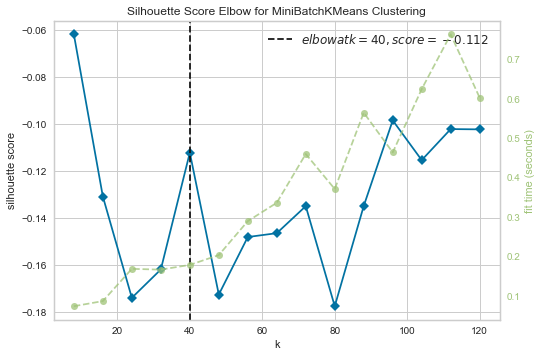

In [320]:
# elbow method to find best k for number of clusters
# !pip install yellowbrick
import numpy as np
from yellowbrick.cluster import KElbowVisualizer

# <--- FIND OPTIMAL K USING THE ELBOW METHOD, NOTE THIS IS EXTREMELY SLOW SO I LEFT IT COMMENTED --->
# model = MiniBatchKMeans(init='k-means++', n_init=2)
# visualizer = KElbowVisualizer(model, metric='silhouette', k=np.arange(1, 5)*500)
# visualizer.fit(onehot_document_term_matrix)
# visualizer.show()
# <--- FIND OPTIMAL K USING THE ELBOW METHOD, NOTE THIS IS EXTREMELY SLOW SO I LEFT IT COMMENTED --->


## Graphs
### Setup graphs from database

In [33]:
def build_graphs(tweet, retweet_graph, mention_graph, reply_graph, hashtag_graph):
    username = tweet.get("user").get("screen_name")
    if tweet.get("retweeted_status"):
        retweet_username = tweet.get("retweeted_status").get("user").get("screen_name")
        if retweet_graph.has_node(username):
            retweet_graph.nodes[username]["retweets"]+=1
        else:
            retweet_graph.add_node(username, retweeted = 0, retweets=1)
        if retweet_graph.has_node(retweet_username):
            retweet_graph.nodes[retweet_username]["retweeted"] += 1
        else:
            retweet_graph.add_node(retweet_username, retweeted = 1, retweets=0)
        if retweet_graph.has_edge(username, retweet_username):
            retweet_graph[username][retweet_username]["weight"] += 1
        else:
            retweet_graph.add_edge(username, retweet_username, weight=1)
    else:
        if tweet.get("in_reply_to_screen_name"):
            reply_username = tweet.get("in_reply_to_screen_name")
            if reply_graph.has_node(username):
                reply_graph.nodes[username]["replied"]+=1
            else:
                reply_graph.add_node(username, replied_to = 0, replied=1)
            if reply_graph.has_node(reply_username):
                reply_graph.nodes[reply_username]["replied_to"] += 1
            else:
                reply_graph.add_node(reply_username, replied_to = 1, replied=0)
            if reply_graph.has_edge(username, reply_username):
                reply_graph[username][reply_username]["weight"] += 1
            else:
                reply_graph.add_edge(username, reply_username, weight=1)
            
        hashtags = tweet.get("entities").get("hashtags")
        if hashtags != []:
            for hashtag in hashtags:
                if hashtag_graph.has_node(hashtag.get("text")):
                    hashtag_graph.nodes[hashtag.get("text")]["uses"]+=1
                else:
                    hashtag_graph.add_node(hashtag.get("text"), uses=1, label=hashtag.get("text"))
        if len(hashtags) > 2:
            for i in range(len(hashtags)-1):
                for j in range(i+1, len(hashtags)):
                    if hashtag_graph.has_edge(hashtags[i].get("text"), hashtags[j].get("text")):
                        hashtag_graph[hashtags[i].get("text")][hashtags[j].get("text")]["weight"] += 1
                    else:
                        hashtag_graph.add_edge(hashtags[i].get("text"), hashtags[j].get("text"), weight=1)
        mentions = tweet.get("entities").get("user_mentions")
        if len(hashtags) != []:
            for user in mentions:
                mention_name = user.get("screen_name")
                if mention_graph.has_node(username):
                    mention_graph.nodes[username]["mentions"]+=1
                else:
                    mention_graph.add_node(username, mentioned = 0, mentions=1)
                if mention_graph.has_node(mention_name):
                    mention_graph.nodes[mention_name]["mentioned"] += 1
                else:
                    mention_graph.add_node(mention_name, mentioned = 1, mentions=0)
                if mention_graph.has_edge(username, mention_name):
                    mention_graph[username][mention_name]["weight"] += 1
                else:
                    mention_graph.add_edge(username, mention_name, weight=1)

In [91]:
# find superusers with more than 10 retweeted tweets to use REST API user timeline search
superusers = []
for node in retweet_graph.nodes():
    if retweet_graph.nodes[node]["retweeted"] > 10:
        superusers.append(node)
print(superusers[:10], "...")
# <--- SEARCH FOR USERS EXTRACTED FROM THE GRAPHS HERE --->
# Note that this is slow, limited to a small number of tweets and devalues the data
# search_users(superusers)
# <--- SEARCH FOR USERS EXTRACTED FROM THE GRAPHS HERE --->

['realDerekUtley', 'gtconway3d', 'TeamTrump', 'realDonaldTrump', 'FlyThaiMMA', 'jeremyscahill', 'Shem_Infinite', 'JoeBiden', 'sunrisemvmt', 'rww_gop'] ...


In [98]:
import networkx as nx
import pymongo
from pymongo import MongoClient
import pandas as pd
import itertools

cluster = False
sample = True
retweet_graph = nx.DiGraph()
mention_graph = nx.DiGraph()
hashtag_graph = nx.Graph()
reply_graph = nx.DiGraph()
if not sample:
    client = MongoClient()
    db = client.twitter_data_full
    print(db, '\n')
    tweets = db.tweets

# build all the graphs from the tweet data, ignore retweets for non-retweet graphs 
if cluster:
    # for tweet in tweets.find({ "_id" : { "$in" : cluster_ids } }):
    for tweet in tweet_frame_cluster.iterrows():
        tweet = tweet[1]
        build_graphs(tweet, retweet_graph, mention_graph, reply_graph, hashtag_graph)
elif sample:
     for tweet in tweet_frame.iterrows():
        tweet = tweet[1]
        build_graphs(tweet, retweet_graph, mention_graph, reply_graph, hashtag_graph)
else:
    for tweet in tweets.find():
        build_graphs(tweet, retweet_graph, mention_graph, reply_graph, hashtag_graph)
print("Finished building graphs.")

Finished building graphs.


In [99]:
mention_census = nx.triadic_census(mention_graph)
reply_census = nx.triadic_census(reply_graph)
hashtag_census = nx.triadic_census(hashtag_graph.to_directed())
retweet_census = nx.triadic_census(retweet_graph)
import pprint
print("Retweet network triadic census:")
pprint.pprint(retweet_census)
print("Reply network triadic census:")
pprint.pprint(reply_census)
print("Mention network triadic census:")
pprint.pprint(mention_census)
print("Hashtag network triadic census:")
pprint.pprint(hashtag_census)

Retweet network triadic census:
{'003': 0,
 '012': 0,
 '021C': 0,
 '021D': 0,
 '021U': 0,
 '030C': 0,
 '030T': 0,
 '102': 0,
 '111D': 0,
 '111U': 0,
 '120C': 0,
 '120D': 0,
 '120U': 0,
 '201': 0,
 '210': 0,
 '300': 0}
Reply network triadic census:
{'003': 2625,
 '012': 300,
 '021C': 0,
 '021D': 0,
 '021U': 0,
 '030C': 0,
 '030T': 0,
 '102': 0,
 '111D': 0,
 '111U': 0,
 '120C': 0,
 '120D': 0,
 '120U': 0,
 '201': 0,
 '210': 0,
 '300': 0}
Mention network triadic census:
{'003': 1308511,
 '012': 24703,
 '021C': 0,
 '021D': 70,
 '021U': 16,
 '030C': 0,
 '030T': 0,
 '102': 0,
 '111D': 0,
 '111U': 0,
 '120C': 0,
 '120D': 0,
 '120U': 0,
 '201': 0,
 '210': 0,
 '300': 0}
Hashtag network triadic census:
{'003': 65,
 '012': 0,
 '021C': 0,
 '021D': 0,
 '021U': 0,
 '030C': 0,
 '030T': 0,
 '102': 18,
 '111D': 0,
 '111U': 0,
 '120C': 0,
 '120D': 0,
 '120U': 0,
 '201': 0,
 '210': 0,
 '300': 1}


In [101]:
def print_stats(graph, in_attr, out_attr):
    max_in = max(graph.nodes(), key = lambda x:graph.nodes[x][in_attr])
    max_out = max(graph.nodes(), key = lambda x:graph.nodes[x][out_attr])
#     for node in graph.nodes():
#         if graph.nodes[node][in_attr] > max_in:
#             max_in = graph[node][in_attr]
#         if graph.nodes[node][out_attr] > max_out:
#             max_out = graph[node][out_attr]
#         except:
#             print(graph.nodes[node])
    print("Number of users: {}\nNumber of links: {}\nMost in degree {} with {} times {}\nMost out degree {} with {} {}\n".format(len(graph.nodes()), len(graph.edges()),
                                                                                                                           max_in, graph.nodes[max_in][in_attr], in_attr,
                                                                                                                           max_out, graph.nodes[max_out][out_attr], out_attr))
print(tweet_frame_cluster.shape[0])
print('Mention graph:')
print_stats(mention_graph, 'mentioned', 'mentions')
print('Reply graph:')
print_stats(reply_graph, 'replied_to', 'replied')
if not cluster and len(retweet_graph.nodes()) !=0:
    print('Retweet graph:')
    print_stats(retweet_graph, 'retweeted', 'retweets')
print("Hashtag graph:\nLength: {}\nHashtags: {}\nAvg hashtag used: {}".format(len(hashtag_graph.edges()), len(hashtag_graph.nodes()), np.mean(np.array([hashtag_graph.nodes[node]["uses"] for node in hashtag_graph.nodes()]))))

13401
Mention graph:
Number of users: 201
Number of links: 125
Most in degree realDonaldTrump with 4 times mentioned
Most out degree danangell11 with 5 mentions

Reply graph:
Number of users: 27
Number of links: 15
Most in degree Dragonfly_Drama with 1 times replied_to
Most out degree Dragonfly_Drama with 1 replied

Hashtag graph:
Length: 3
Hashtags: 9
Avg hashtag used: 1.2222222222222223


## Plot hashtag graph - note this is slow for big datasets


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
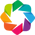

:Overlay
   .Graph.I  :Graph   [start,end]   (weight)
   .Labels.I :Labels   [x,y]   (label)

In [66]:
# !pip install holoviews
# !pip install scikit-image
# !pip install xarray
# !pip install datashader
import matplotlib.pyplot as plt
import networkx.drawing
import holoviews as hv
import copy
from holoviews import opts
from holoviews.operation.datashader import datashade, bundle_graph
use_limit = 5


limited_hashtags = hashtag_graph
nodes = copy.deepcopy(limited_hashtags.nodes())
for node in nodes:
    if limited_hashtags.nodes[node]['uses'] < use_limit:
        limited_hashtags.remove_node(node)
        
hv.extension('bokeh')
defaults = dict(width=800, height=800, padding=0.1)
hv.opts.defaults(
    opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults))
visualisation = hv.Graph.from_networkx(limited_hashtags, nx.fruchterman_reingold_layout, k=1)
visualisation.opts(cmap='Inferno_r', edge_cmap='Cividis_r', node_size=10, edge_color='weight', node_color='uses')

bundled = bundle_graph(visualisation)


labels = hv.Labels(visualisation.nodes, ['x', 'y'], 'label')
(bundled * labels.opts(text_font_size='6pt', text_color='Gray', yoffset=0.025))


## Plot mention graph - note this is slow for big datasets

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
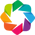

:Graph   [start,end]   (weight)

In [67]:
import matplotlib.pyplot as plt
import networkx.drawing
import holoviews as hv
import copy
from holoviews import opts
from holoviews.operation.datashader import datashade, bundle_graph
use_limit = 20
nodes = copy.deepcopy(mention_graph.nodes())
for node in nodes:
    if mention_graph.nodes[node]['mentions'] + mention_graph.nodes[node]['mentioned'] < use_limit:
        mention_graph.remove_node(node)

hv.extension('bokeh')
defaults = dict(width=800, height=800, padding=0.1)
hv.opts.defaults(
    opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults))
mention_v = hv.Graph.from_networkx(mention_graph, nx.fruchterman_reingold_layout, k=1)
mention_v.opts(cmap='Inferno_r', edge_cmap='Cividis_r', node_size=10, edge_color='weight', node_color='mentions')

mention_b = bundle_graph(mention_v)
mention_b

# Export a part of sample data

In [102]:
import json
with open('sample.json', 'w+') as outfile:
    tweetlist = {}
    tweetlist["tweets"]=[]
    for tweet in tweets.find().limit(1000):
        tweetlist["tweets"].append(tweet)
    outfile.write(json.dumps(tweetlist))
